In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import pickle

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from pykalman import KalmanFilter

import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.svm import SVC

# Formating from raw data

In [2]:
df_input = pd.read_csv(
    "./rasp/measurements_1200cm.csv",
    delimiter = ";", 
    header=None
)

col_names = ["col_1", "col_2"]
df_input.columns = col_names
df_input.dropna()

address = df_input[df_input.col_1=="address"]
rssi = df_input[df_input.col_1=="rssi"]
df_output = pd.DataFrame()
df_output['address'] = address.col_2.values
df_output['rssi'] = rssi.col_2.values


df_output.to_csv ('./rasp/clean/measurements_1200cm_formated.csv', sep = ';', index=False, header=True)

# Importing data

In [4]:
df50 = pd.read_csv("./rasp/clean/measurements_50cm_formated.csv", delimiter = ";")
df100 = pd.read_csv("./rasp/clean/measurements_100cm_2_formated.csv", delimiter = ";")
df200 = pd.read_csv("./rasp/clean/measurements_200cm_formated.csv", delimiter = ";")
df300 = pd.read_csv("./rasp/clean/measurements_300cm_formated.csv", delimiter = ";")
df400 = pd.read_csv("./rasp/clean/measurements_400cm_formated.csv", delimiter = ";")
df500 = pd.read_csv("./rasp/clean/measurements_500cm_formated.csv", delimiter = ";")
df600 = pd.read_csv("./rasp/clean/measurements_600cm_formated.csv", delimiter = ";")
df700 = pd.read_csv("./rasp/clean/measurements_700cm_formated.csv", delimiter = ";")
df800 = pd.read_csv("./rasp/clean/measurements_800cm_formated.csv", delimiter = ";")
df900 = pd.read_csv("./rasp/clean/measurements_900cm_formated.csv", delimiter = ";")
df1000 = pd.read_csv("./rasp/clean/measurements_1000cm_formated.csv", delimiter = ";")
df1100 = pd.read_csv("./rasp/clean/measurements_1100cm_formated.csv", delimiter = ";")
df1200 = pd.read_csv("./rasp/clean/measurements_1200cm_formated.csv", delimiter = ";")

df50['dist'] = 50
df100['dist'] = 100
df200['dist'] = 200
df300['dist'] = 300
df400['dist'] = 400
df500['dist'] = 500
df600['dist'] = 600
df700['dist'] = 700
df800['dist'] = 800
df900['dist'] = 900
df1000['dist'] = 1000
df1100['dist'] = 1100
df1200['dist'] = 1200

to_concat = [df50, df100, df200, df300, df400, df500, df600, df700, df800, df900, df1000, df1100]
total_df = pd.concat(to_concat)

total_df = total_df.reset_index(drop=True)

In [5]:
mappping_battery = {'ef:86:35:dd:c3:f7' : 69,
                    'e2:51:e0:31:ee:0e' : 20,
                    'f7:9c:08:9a:42:ed' : 50,
                    'f1:96:cd:ee:25:bd' : 47,
                    'e3:6f:28:36:5a:db' : 43,
                    'd5:b1:89:8b:b8:c5' : 67,
                    'fc:02:a0:fa:33:19' : 44, 
                    'f9:b3:b2:3d:53:a5' : 72,
                    'd1:0b:14:b3:18:6a' : 43,
                   }

In [6]:
total_df['battery'] = total_df.address.map(mappping_battery)
total_df['txPower'] = 6
total_df['interval'] = 500

total_df = total_df[~total_df.battery.isna()]

total_df = total_df.reset_index(drop=True)
total_df.dist.value_counts().min()

7635

In [2]:
total_df.dist.value_counts()

NameError: name 'total_df' is not defined

In [3]:
temp = pd.DataFrame()

min_nb = total_df.dist.value_counts().min()
#min_nb = 2000
distances = total_df.dist.unique()

for dist in distances:
    temp = pd.concat([temp, total_df[total_df.loc[:,'dist'] == dist].iloc[0:min_nb,:]])

total_df = temp

NameError: name 'total_df' is not defined

In [ ]:
sns.displot(total_df, x="rssi", hue="dist", kind="kde",fill=True, palette = sns.color_palette("hls",len(distances)))

# Pre-processing

In [4]:
tx = 6 #beacon tx
ref = -64 #from kontakt

def db_to_meters(RSSI, measure_ref, N):
        """
        Converts dB to meters.
        """
        d = 10 ** ((measure_ref - RSSI) / (10 * N))
        return d

def meters_to_db(dist, measure_ref, N):
    """
    Converts meters to DB
    """
    return measure_ref-10*N*np.log10(dist)

In [5]:
def rolling_window(test_df, filter_size, var_coeff):
    test_df = test_df.reset_index(drop=True)
    test_df.loc[:,'roll']=np.nan
    for i in range(filter_size,  test_df.shape[0]):
            temp = test_df.iloc[i-filter_size:i]
            temp = temp.reset_index(drop=True)
            if bool(all(elem == temp.dist[0] for elem in temp.dist)) :
                var = var_coeff * temp.loc[:,'rssi'].var()
                initial_value_guess = meters_to_db(temp.dist[filter_size-1]/100, ref, tx) 
                observation_covariance = np.diag([var]) ** 2
                kf = KalmanFilter(
                initial_state_mean = initial_value_guess,
                initial_state_covariance = observation_covariance,
                observation_covariance = observation_covariance
                )

                pred_state, state_cov = kf.smooth(np.flip(temp.loc[:,'rssi']))

                test_df.loc[i-1,'roll'] = pred_state[filter_size-1]
    return test_df

#test_df = rolling_window(total_df, 50, 10)

In [6]:
def kalmanFilter(temp):
    var_coeff = 15
    var = var_coeff * temp.var()
    initial_value_guess = db_to_meters(temp.iloc[-1]/100, ref, tx) 
    observation_covariance = np.diag([var]) ** 2
    kf = KalmanFilter(
    initial_state_mean = initial_value_guess,
    initial_state_covariance = observation_covariance,
    observation_covariance = observation_covariance
    )
    pred_state, state_cov = kf.smooth(np.flip(temp))
    return pred_state[-1]

In [7]:
distances = total_df.dist.unique()
distances
test_df = total_df

NameError: name 'total_df' is not defined

In [ ]:
for dist in distances:
    indexes = test_df.dist==dist
    test_df.loc[indexes, "roll"] = test_df.loc[indexes, "rssi"].rolling(60).apply(kalmanFilter)
    
test_df = test_df.dropna().reset_index(drop=True)

In [15]:
test_df.to_csv ('name.csv', index=False, header=True)

In [8]:
test_df = pd.read_csv("./Rasp_Pre_processed_size_60_varCoeff_15_7635_samples.csv")

In [9]:
test_df

,address,rssi,dist,battery,txPower,interval,roll
0,ef:86:35:dd:c3:f7,-57,50,69,6,500,-51.130423
1,e3:6f:28:36:5a:db,-52,50,43,6,500,-51.146852
2,d1:0b:14:b3:18:6a,-57,50,43,6,500,-51.574123
3,d5:b1:89:8b:b8:c5,-41,50,67,6,500,-51.377467
4,e2:51:e0:31:ee:0e,-47,50,20,6,500,-51.377793
...,...,...,...,...,...,...,...
90907,ef:86:35:dd:c3:f7,-70,1100,69,6,500,-69.294878
90908,f7:9c:08:9a:42:ed,-69,1100,50,6,500,-69.294941
90909,e3:6f:28:36:5a:db,-78,1100,43,6,500,-69.458827
90910,d5:b1:89:8b:b8:c5,-74,1100,67,6,500,-69.737937


In [12]:
sns.displot(test_df, x="roll", hue="dist", kind="kde",fill=True, palette = sns.color_palette("hls",len(distances)))

NameError: name 'distances' is not defined

In [13]:
import random

distances = test_df.dist.unique()

to_keep_for_train = 750
index = []
temp_train = pd.DataFrame()
temp_test = pd.DataFrame()

for dist in distances:
    min_nb = len(test_df[test_df.loc[:,'dist'] == dist])
    index_to_test = [random.randrange(1, min_nb, 1) for i in range(to_keep_for_train)]
    index_tot = index_tot = np.linspace(0,min_nb-1,min_nb)
    index_to_train = np.setdiff1d(index_tot, index_to_test)
    temp_train = pd.concat([temp_train, test_df[test_df.loc[:,'dist'] == dist].reset_index(drop=True).iloc[index_to_train,:]])
    temp_test = pd.concat([temp_test, test_df[test_df.loc[:,'dist'] == dist].reset_index(drop=True).iloc[index_to_test,:]])
                          
train_set = temp_train.reset_index(drop=True)
test_set = temp_test.reset_index(drop=True)

# Feature augmentation

In [14]:
def feature_augmentation(X):
        return np.array([X, X**2, X**3, X**4, X**5]).transpose()

def feature_augmentation_func(test_set):

    test_set = test_set[~test_set.roll.isnull()]
    test_set = test_set.reset_index(drop=True)
    X = feature_augmentation(test_set.roll.values)
    #X = np.concatenate([feature_augmentation(test_set.roll.values), feature_augmentation(db_to_meters(test_set.roll, ref, tx))], axis = 1)
    #X = feature_augmentation(db_to_meters(test_set.roll, ref, tx))
    y = test_set.dist.values

    #Pre-processing
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    ones = np.ones([X_scaled.shape[0],1])
    X_scaled = np.concatenate([ones, X_scaled], axis = 1)
    
    filename = 'scaler.sav'
    pickle.dump(scaler, open(filename, 'wb'))
    
    #Train - test split
    return X_scaled, y


In [15]:
feature_df = pd.DataFrame(train_set[["roll","dist"]])

X_scaled, y = feature_augmentation_func(feature_df)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)  

# Model testing

## Random Forest Regressor - rfr

### - Grid Search

In [48]:
rfr_class = RandomForestRegressor(n_jobs=-1, random_state=0)

parameters = {'n_estimators':[500, 750, 1000, 2000, 3000], 'max_depth':[10, 15, 20, 30, 40, 50]}

rfr_GS = GridSearchCV(rfr_class, parameters, verbose=3)

rfr_GS.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ....max_depth=10, n_estimators=500;, score=0.927 total time=  27.6s
[CV 2/5] END ....max_depth=10, n_estimators=500;, score=0.927 total time=  23.3s
[CV 3/5] END ....max_depth=10, n_estimators=500;, score=0.927 total time=  23.9s
[CV 4/5] END ....max_depth=10, n_estimators=500;, score=0.926 total time=  24.3s
[CV 5/5] END ....max_depth=10, n_estimators=500;, score=0.927 total time=  31.9s
[CV 1/5] END ....max_depth=10, n_estimators=750;, score=0.927 total time=  56.6s
[CV 2/5] END ....max_depth=10, n_estimators=750;, score=0.927 total time=  49.9s
[CV 3/5] END ....max_depth=10, n_estimators=750;, score=0.927 total time=  42.2s
[CV 4/5] END ....max_depth=10, n_estimators=750;, score=0.926 total time=  43.4s
[CV 5/5] END ....max_depth=10, n_estimators=750;, score=0.927 total time=  46.6s
[CV 1/5] END ...max_depth=10, n_estimators=1000;, score=0.927 total time= 1.2min
[CV 2/5] END ...max_depth=10, n_estimators=1000

[CV 2/5] END ....max_depth=40, n_estimators=500;, score=0.903 total time= 1.1min
[CV 3/5] END ....max_depth=40, n_estimators=500;, score=0.906 total time= 1.1min
[CV 4/5] END ....max_depth=40, n_estimators=500;, score=0.906 total time= 1.1min
[CV 5/5] END ....max_depth=40, n_estimators=500;, score=0.906 total time= 1.1min
[CV 1/5] END ....max_depth=40, n_estimators=750;, score=0.905 total time= 1.6min
[CV 2/5] END ....max_depth=40, n_estimators=750;, score=0.903 total time= 1.6min
[CV 3/5] END ....max_depth=40, n_estimators=750;, score=0.906 total time= 1.6min
[CV 4/5] END ....max_depth=40, n_estimators=750;, score=0.906 total time= 1.6min
[CV 5/5] END ....max_depth=40, n_estimators=750;, score=0.906 total time= 1.7min
[CV 1/5] END ...max_depth=40, n_estimators=1000;, score=0.905 total time= 2.1min
[CV 2/5] END ...max_depth=40, n_estimators=1000;, score=0.903 total time= 2.2min
[CV 3/5] END ...max_depth=40, n_estimators=1000;, score=0.906 total time= 2.1min
[CV 4/5] END ...max_depth=40

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [10, 15, 20, 30, 40, 50],
                         'n_estimators': [500, 750, 1000, 2000, 3000]},
             verbose=3)

In [49]:
print(rfr_GS.best_params_)

{'max_depth': 15, 'n_estimators': 3000}


### - Training

In [61]:
rfr = RandomForestRegressor(max_depth = 15, n_estimators = 3000, n_jobs=-1)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=3000, n_jobs=-1)

                 0
count  8235.000000
mean     60.888582
std      67.535501
min       0.000000
25%       9.039704
50%      44.087931
75%      83.798429
max     429.821646


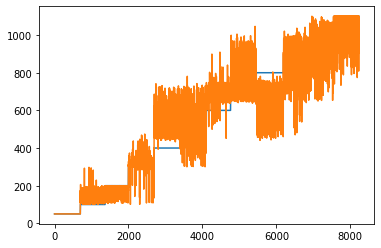

In [62]:
predicted = rfr.predict(X_test)
expected = y_test
print(pd.DataFrame(np.abs(expected - predicted)).describe())

to_plot= pd.concat([pd.DataFrame(expected), pd.DataFrame(predicted)], axis=1)
to_plot.columns = ['dist', 'pred']
to_plot = to_plot.sort_values(by=['dist'], ignore_index=True)
plt.plot(to_plot)

## Gradient Boosting Regressor

### - Grid search

In [67]:
GBR_class = GradientBoostingRegressor(random_state=0)

parameters = {'learning_rate':[1e-1, 1e-2, 1e-3], 'n_estimators':[5000, 7500, 10000, 15000], 'subsample':[0.25, 0.5, 0.75]}

gbr_GS = GridSearchCV(GBR_class, parameters, n_jobs=-1, verbose=3, cv =3)

gbr_GS.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [5000, 7500, 10000, 15000],
                         'subsample': [0.25, 0.5, 0.75]},
             verbose=3)

In [68]:
print(gbr_GS.best_params_)

{'learning_rate': 0.01, 'n_estimators': 15000, 'subsample': 0.25}


### - Training

In [73]:
GBR = GradientBoostingRegressor(random_state=0, learning_rate = 1e-2, n_estimators=15000, subsample = 0.25)
GBR.fit(X_train, y_train)


GradientBoostingRegressor(learning_rate=0.01, n_estimators=15000,
                          random_state=0, subsample=0.25)

                 0
count  8235.000000
mean     61.742505
std      66.324805
min       0.032926
25%      11.337098
50%      44.542216
75%      84.115119
max     437.508790


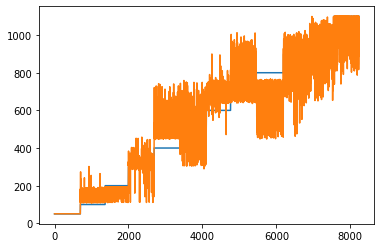

In [74]:
predicted = GBR.predict(X_test)
expected = y_test
print(pd.DataFrame(np.abs(expected - predicted)).describe())

to_plot= pd.concat([pd.DataFrame(expected), pd.DataFrame(predicted)], axis=1)
to_plot.columns = ['dist', 'pred']
to_plot = to_plot.sort_values(by=['dist'], ignore_index=True)
plt.plot(to_plot)

## Support Vector Classifier

### - Grid Search

In [16]:
SVC_class = SVC()

parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'tol':[1e-2,1e-3,1e-4], 'decision_function_shape':['ovo','ovr']}

SVC_GS = GridSearchCV(SVC_class, parameters, n_jobs=-1, verbose=3, cv =3)

SVC_GS.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'decision_function_shape': ['ovo', 'ovr'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'tol': [0.01, 0.001, 0.0001]},
             verbose=3)

In [18]:
print(SVC_GS.best_params_)

{'decision_function_shape': 'ovo', 'kernel': 'rbf', 'tol': 0.01}


### - Training

In [42]:
svc = SVC(kernel = 'rbf', tol= 1e-2, cache_size = 4000, decision_function_shape= 'ovo')
svc.fit(X_train, y_train)

SVC(cache_size=4000, decision_function_shape='ovo', tol=0.01)

                 0
count  8235.000000
mean     57.765634
std      97.870754
min       0.000000
25%       0.000000
50%       0.000000
75%     100.000000
max     500.000000


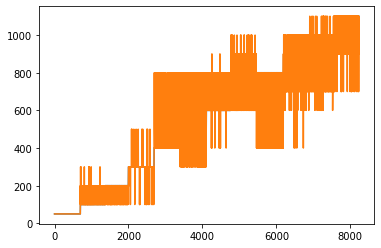

In [43]:
predicted = svc.predict(X_test)
expected = y_test
print(pd.DataFrame(np.abs(expected - predicted)).describe())

to_plot= pd.concat([pd.DataFrame(expected), pd.DataFrame(predicted)], axis=1)
to_plot.columns = ['dist', 'pred']
to_plot = to_plot.sort_values(by=['dist'], ignore_index=True)
plt.plot(to_plot)

## Support Vector Regressor

### - Grid search

In [11]:
SVR_class = SVR(cache_size= 3000)

parameters = {'kernel':['rbf'], 'epsilon':[1e-5], 'tol':[1e-4], 'C':[25, 75, 100]}
#, 'C':[1, 10, 100]

svr = GridSearchCV(SVR_class, parameters, n_jobs=-1, verbose=4, cv=3)

svr.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3, estimator=SVR(cache_size=3000), n_jobs=-1,
             param_grid={'C': [25, 75, 100], 'epsilon': [1e-05],
                         'kernel': ['rbf'], 'tol': [0.0001]},
             verbose=4)

In [12]:
print(svr.best_params_)

{'C': 25, 'epsilon': 1e-05, 'kernel': 'rbf', 'tol': 0.0001}


### - Training

In [13]:
SVR_model = SVR(kernel = 'rbf', epsilon=1e-5, degree = 1, cache_size= 4000, tol=1e-4 , C=25)
SVR_model.fit(X_train, y_train)

SVR(C=25, cache_size=4000, degree=1, epsilon=1e-05, tol=0.0001)

                 0
count  8232.000000
mean     71.662265
std      75.040606
min       0.000053
25%       9.241652
50%      49.880183
75%     100.645372
max     446.024867


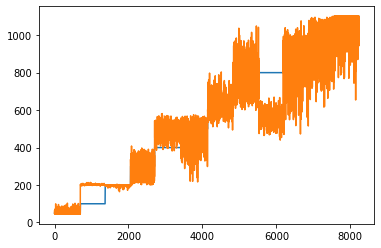

In [57]:
predicted = SVR_model.predict(X_test)
expected = y_test
print(pd.DataFrame(np.abs(expected - predicted)).describe())

to_plot= pd.concat([pd.DataFrame(expected), pd.DataFrame(predicted)], axis=1)
to_plot.columns = ['dist', 'pred']
to_plot = to_plot.sort_values(by=['dist'], ignore_index=True)
plt.plot(to_plot)

## Post-processing

In [75]:
to_plot = to_plot.reset_index(drop=True)
filter_size = 30
to_plot.loc[:,'pred_filter']=np.nan
for i in range(filter_size,  to_plot.shape[0]):
        temp = to_plot.iloc[i-filter_size:i]
        temp = temp.reset_index(drop=True)
        if bool(all(elem == temp.dist[0] for elem in temp.dist)) :
            var = 10* temp.loc[:,'pred'].var()
            initial_value_guess = meters_to_db(temp.dist[filter_size-1]/100, ref, tx) 
            observation_covariance = np.diag([var]) ** 2
            kf = KalmanFilter(
            initial_state_mean = initial_value_guess,
            initial_state_covariance = observation_covariance,
            observation_covariance = observation_covariance
            )

            pred_state, state_cov = kf.smooth(np.flip(temp.loc[:,'pred']))

            to_plot.loc[i-1,'pred_filter'] = pred_state[filter_size-1]
    

                 0
count  7886.000000
mean     56.759213
std      43.298689
min       0.006263
25%      26.483335
50%      47.761869
75%      82.011761
max     190.942532


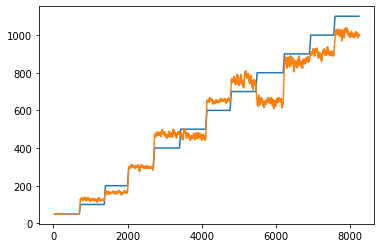

In [76]:
to_plot
to_plot = to_plot[~to_plot.pred_filter.isnull()]
print(pd.DataFrame(np.abs(to_plot.dist - to_plot.pred_filter)).describe())

plt.plot(to_plot.dist)
plt.plot(to_plot.pred_filter)

## Exporting the model

In [80]:
filename = 'gbr_reg_kalman.sav'
pickle.dump(GBR, open(filename, 'wb'))

import joblib
joblib.dump(GBR, "gbr_compressed.gz", compress=8)


['gbr_compressed.gz']

## Testing

In [65]:
test_set

,address,rssi,dist,battery,txPower,interval,roll
0,e3:6f:28:36:5a:db,-52,50,43,6,500,-51.180006
1,f9:b3:b2:3d:53:a5,-41,50,72,6,500,-52.458145
2,f9:b3:b2:3d:53:a5,-44,50,72,6,500,-48.884112
3,f7:9c:08:9a:42:ed,-63,50,50,6,500,-51.573351
4,f9:b3:b2:3d:53:a5,-42,50,72,6,500,-50.245087
...,...,...,...,...,...,...,...
8995,f9:b3:b2:3d:53:a5,-78,1100,72,6,500,-71.065605
8996,f1:96:cd:ee:25:bd,-66,1100,47,6,500,-72.656655
8997,d1:0b:14:b3:18:6a,-66,1100,43,6,500,-72.329054
8998,fc:02:a0:fa:33:19,-68,1100,44,6,500,-71.950068


In [66]:
import random

distances = [800, 50, 300, 600, 200, 1000, 500, 100, 700, 1100,400,900]
min_nb=500
temp=pd.DataFrame()
for dist in distances:
    temp = pd.concat([temp, test_set[test_set.loc[:,'dist'] == dist].reset_index(drop=True)])

test_set_local = temp.reset_index(drop=True)

In [67]:
to_plot = test_set_local.reset_index(drop=True)
filter_size = 60
for i in range(filter_size,  to_plot.shape[0]):
        temp = to_plot.iloc[i-filter_size:i]
        temp = temp.reset_index(drop=True)
        var = 15* temp.loc[:,'rssi'].var()
        initial_value_guess = meters_to_db(temp.dist[filter_size-1]/100, ref, tx) 
        observation_covariance = np.diag([var]) ** 2
        kf = KalmanFilter(
        initial_state_mean = initial_value_guess,
        initial_state_covariance = observation_covariance,
        observation_covariance = observation_covariance
        )

        pred_state, state_cov = kf.smooth(np.flip(temp.loc[:,'rssi']))

        to_plot.loc[i-1,'roll'] = pred_state[filter_size-1]

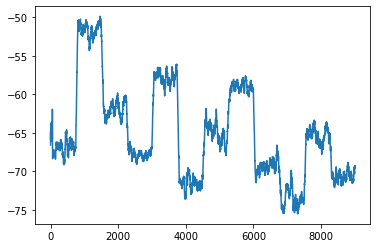

In [68]:
plt.plot(to_plot.roll)

In [69]:
test_aug, expected = feature_augmentation_func(to_plot)

                 0
count  9000.000000
mean     78.899260
std      88.033710
min       0.000000
25%      24.941400
50%      50.850904
75%     103.832818
max     884.830042


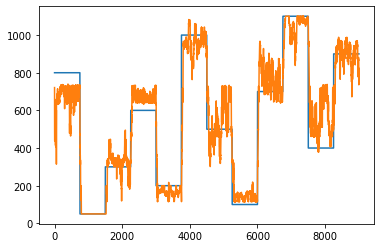

In [70]:
predicted = rfr.predict(test_aug)
print(pd.DataFrame(np.abs(expected - predicted)).describe())

to_plot= pd.concat([pd.DataFrame(expected), pd.DataFrame(predicted)], axis=1)
to_plot.columns = ['dist', 'pred']
plt.plot(to_plot)

In [71]:
filter_size = 30

to_plot = to_plot.reset_index(drop=True)

for i in range(filter_size,  to_plot.shape[0]):
    temp = to_plot.iloc[i-filter_size:i]
    var = 10 * temp.loc[:,'pred'].var()
    initial_value_guess = temp.pred[i-1]
    observation_covariance = np.diag([var]) ** 2
    kf = KalmanFilter(
    initial_state_mean = initial_value_guess,
    initial_state_covariance = observation_covariance,
    observation_covariance = observation_covariance
    )

    pred_state, state_cov = kf.smooth(np.flip(temp.loc[:,'pred']))

    to_plot.loc[i-1,'pred_filter'] = pred_state[filter_size-1]
to_plot.dropna()

,dist,pred,pred_filter
29,800,414.088117,513.206420
30,800,596.313605,515.059262
31,800,502.487083,511.511946
32,800,465.946798,506.142590
33,800,545.685563,510.038506
...,...,...,...
8994,900,794.610739,837.956420
8995,900,800.064694,834.878358
8996,900,735.931335,828.631190
8997,900,779.155305,827.204376


                 0
count  8970.000000
mean     83.103411
std     100.155658
min       0.000000
25%      24.402459
50%      51.857715
75%     106.649462
max     829.540474


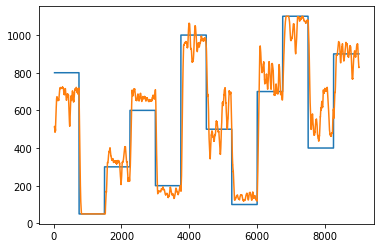

In [72]:
to_plot
to_plot = to_plot[~to_plot.pred_filter.isnull()]
print(pd.DataFrame(np.abs(to_plot.dist - to_plot.pred_filter)).describe())

plt.plot(to_plot.dist)
plt.plot(to_plot.pred_filter)